# Chebyshev for BVPs

In [1]:
include("smij-functions.jl");

For the most part, we can drop in a Chebyshev differentiation matrix where we previously used finite differences, but there are some important differences to keep in mind.

## 1D BVP

Consider 

$$
\partial_{xx} u = e^{4x}, \qquad u(\pm 1) = 0. 
$$

Unlike FD methods, a reasonable way to get the matrix $\bfD_{xx}$ is by squaring $\bfD_x$. (We drop the $N$ subscript for notational sanity.) Mathematically, both reduce to evaluation of the 2nd derivative of the global polynomial interpolant. For the homogeneous Dirichlet conditions in this example, the numerical solution satisfies $v_0=v_N=0$, so we can remove both them and the columns of $\bfD_{xx}$ that they multiply from the linear system $\bfD_{xx} = \exp(4\bfx)$. 

The solution of the linear system produces the grid function $v$ at Chebyshev points. Unlike FD methods, however, these values also imply a global interpolant over the solution domain. In fact, it would be a crime to use linear interpolation or a cubic spline for off-grid points, as those methods would erase the advantage of spectral accuracy (though you would be unlikely to notice much on a plot of the solution for any smooth method). We use the `polyinterp` function defined earlier to evaluate the solution anywhere; in principle, we should specialize it to Chebyshev points, for which the barycentric weights are known in closed form, but the performance issue is not meaningful to us for these demonstrations.

## Linear BVP

$$u_{xx} = \exp(4x),\; u(-1)=u(1)=0$$

### p13: solve linear BVP

In [2]:
N = 16
D, x = cheb(N)
D² = (D^2)[2:N, 2:N]                   # boundary conditions
f = @. exp(4x[2:N])
u = D² \ f                           # Poisson eq. solved here
u = [0; u; 0]
xx = -1:0.01:1
uu = polyinterp(x, u).(xx)      # interpolate grid data
exact = @. (exp(4xx) - sinh(4) * xx - cosh(4)) / 16
err = norm(uu - exact,Inf)

1.2609646660166618e-10

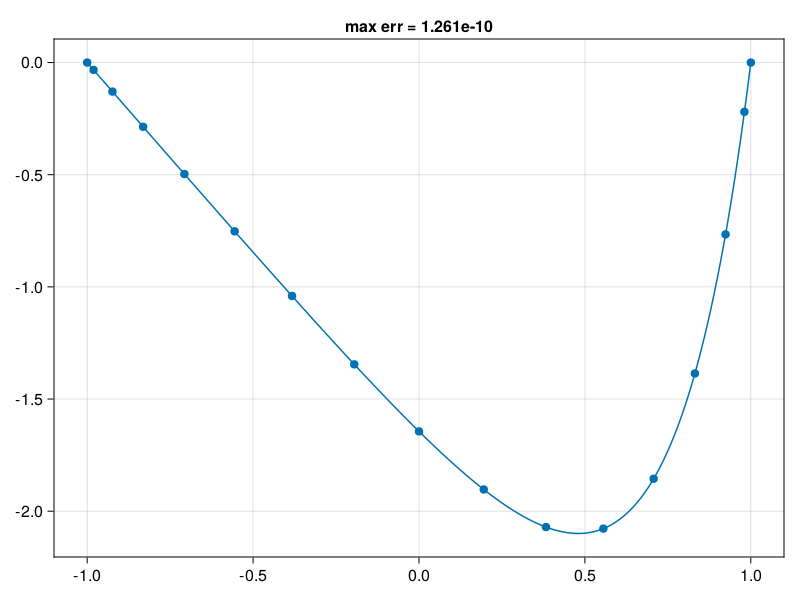

In [3]:
using CairoMakie, PyFormattedStrings

fig = Figure()
Axis( fig[1, 1], title=f"max err = {norm(uu-exact,Inf):.4g}" )
scatter!(x, u)
lines!(xx, uu) 
fig

## Nonlinear BVP

For the nonlinear variant 

$$
\partial_{xx} u = e^{u}, \qquad u(\pm 1) = 0, 
$$

we again derive a nonlinear algebraic system by discretization. Here is a code that uses a fixed-point iteration to approximately solve the nonlinear system:

### p14: solve nonlinear BVP

In [4]:
N = 16
D, x = cheb(N)
D² = (D^2)[2:N, 2:N]
u = zeros(N - 1)
change = 1
it = 0
while change > 1e-15                   # fixed-point iteration
    unew = D² \ exp.(u)
    change = norm(unew - u, Inf)
    u = unew
    it += 1
end
u = [0; u; 0]
xx = -1:0.01:1
uu = polyinterp(x,u).(xx);

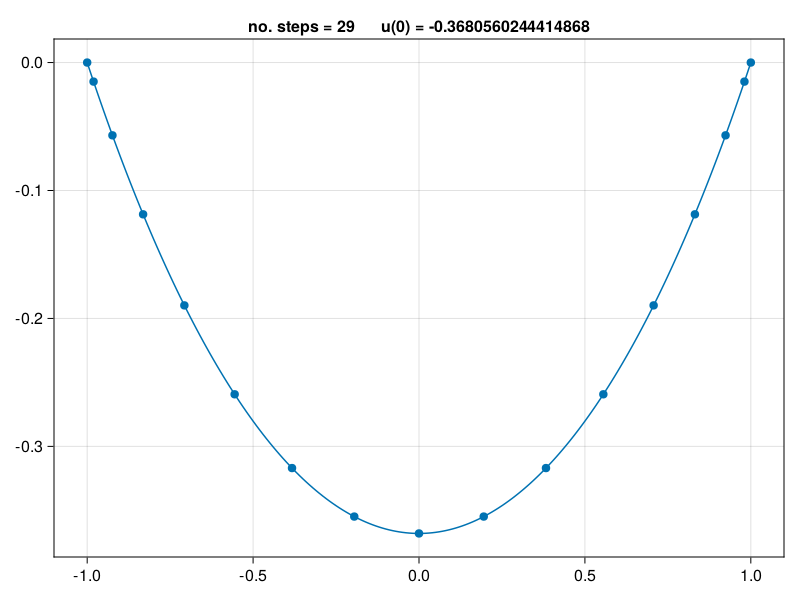

In [5]:
fig = Figure()
Axis( fig[1, 1], title="no. steps = $it      u(0) = $(u[N÷2+1])" )
scatter!(x, u)
lines!(xx, uu)
fig

Recall that there are two senses of convergence here: convergence of the iteration as a solution of the discrete equations, and convergence of the discretization to the underlying solution function.

## Eigenvalues

We can also solve the Laplacian eigenvalue problem 

$$
\partial_{xx} u = \lambda {u}, \qquad u(\pm 1) = 0.
$$

We have the exact solutions 

$$
\lambda_n = -\frac{n^2\pi^2}{4}, \qquad u_n(x) = \sin[n\pi(x+1)/2], \qquad n = 1,2,\dots. 
$$

### p15: solve eigenvalue BVP

In [6]:
N = 36
D, x = cheb(N)
D² = (D^2)[2:N, 2:N]
λ, V = eigen(D², sortby = (-)∘real)
xx = -1:0.01:1
results = []
for j in 5:5:30                  # plot 6 eigenvectors
    u = [0; V[:, j]; 0]
    uu = polyinterp(x,u).(xx)
    push!(results, (;j,u,uu))
end

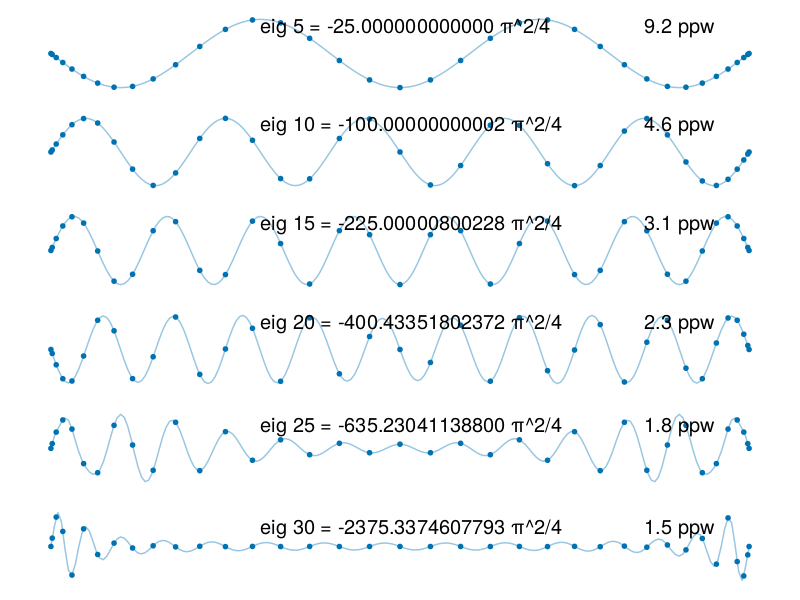

In [7]:
using Makie.Colors
fig = Figure()
for (i,r) in enumerate(results)
    ax = Axis(fig[i, 1])
    scatter!(x, r.u, markersize=8)
    line = lines!(xx, r.uu, linealpha=0.5)
    color = line.color[]
    line.color[] = Colors.RGBA(color.r,color.g,color.b,0.4)
    hidespines!(ax); hidedecorations!(ax)
    j = r.j
    text!(-0.4, 0.12, text=f"eig {j} = {λ[j]*4/π^2:#.14g} π^2/4", textsize=20)
    text!(0.7, 0.12, text=f"{4*N/(π*j):.2g} ppw", textsize=20)
end
fig

Observe above that the results become increasingly inaccurate as the eigenfunction wavenumber increases. The resolution of a method is often expressed in terms of **points per wavelength (PPW)**, which is the wavelength divided by the grid spacing. As a reference, in Fourier methods the highest wavenumber that can be resolved is $k=N/2$, and the PPW in this case is

$$
\frac{4\pi/N}{2\pi/N} = 2. 
$$

Thus, 2 PPW is the bare minimum for a Fourier spectral method. 

For a Chebyshev method, the points are coarsest in the center of the grid, where the node density is $1/\pi$. This compares to an equispaced node density (on $[-1,1]$) of $1/2$, so we lose a factor of $\pi/2$ in resolution at the center by comparison. It's therefore reasonable to state that Chebyshev methods have a $\pi$ PPW minimum resolution requirement.

In the example above, the wavelength of the $n$th mode is $4/n$. Compared to $h=\pi/N$ at the center, the effective PPW is therefore $4N/(n\pi)$ at mode $n$. The figure shows that about 7 digits are correct at PPW 3.1, but the accuracy falls off quickly beyond that.

## 2D Poisson

For problems over a rectangle, we can use Kronecker products on a tensor product of Chebyshev grids. The resulting discrete approximation to, say, the Laplacian operator is less sparse than we see with finite differences, the idea is that a much smaller matrix will suffice for equivalent accuracy. If the matrix is truly too large to handle with dense linear algebra, then one can turn to iterative methods with a fast evaluation alternative to be presented in the next section.

One new wrinkle in 2D is that the interpolant must also be evaluated in a tensor-product fashion. For example, suppose a grid function has $U_{ij}$ given at all $(x_i,y_j)$ for independent Chebyshev grids in $x$ and $y$. To evaluate the interpolant at $(\xi,\eta)$, we first evaluate 1D interpolants at $(\xi,y_j)$ for all $j$, and then do one more 1D evaluation at $(\xi,\eta)$. This can be visualized as collapsing each column of data down to the point $\xi$, then collapsing the remaining row to a single point. In practice we can do this reasonably efficiently on a grid of $(\xi,\eta)$ values, and we implement that as `gridinterp`.

In [8]:
function gridinterp(V,xx,yy)
    M,N = size(V) .- 1
    Vx = zeros(length(xx), N+1)
    for j in axes(V,2)
        Vx[:,j] = polyinterp(V[:,j]).(xx)
    end
    VV = zeros(length(xx),length(yy))
    for i in axes(Vx,1)
        VV[i,:] = polyinterp(Vx[i,:]).(yy)
    end
    return VV
end;

Here is a solution of $\Delta u = 10\sin(8x(y-1))$ over $[-1,1]^2$ with homogeneous Dirichlet conditions:

### p16: Poisson eq. on [-1,1]×[-1,1] with $u=0$ on boundary

In [9]:
N = 24
# Set up grids and tensor product Laplacian and solve for u:
⊗ = kron
D, x = D, y = cheb(N)
F = [ 10sin(8x * (y - 1)) for x in x[2:N], y in y[2:N] ]
D² = (D^2)[2:N, 2:N]
L = I(N-1) ⊗ D² + D² ⊗ I(N-1)                     # Laplacian

u = L \ vec(F)           # solve problem 

# Reshape long 1D results onto 2D grid (flipping orientation):
U = zeros(N+1, N+1)
U[2:N, 2:N] = reshape(u, N-1, N-1)
value = U[N÷4 + 1, N÷4 + 1]

# Interpolate to finer grid:
xx = yy = -1:0.04:1
UU = gridinterp(U,xx,yy);

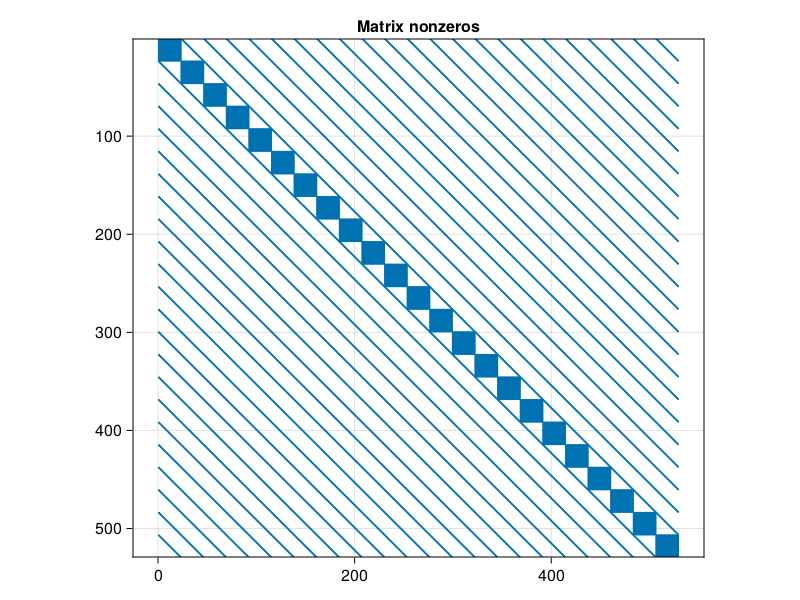

In [10]:
using SparseArrays
fig = Figure()
Axis(fig[1, 1], title="Matrix nonzeros", aspect=DataAspect())
row,col,_ = findnz(sparse(L))
scatter!(row, col, markersize=3)
ylims!((N-1)^2, 1)
fig

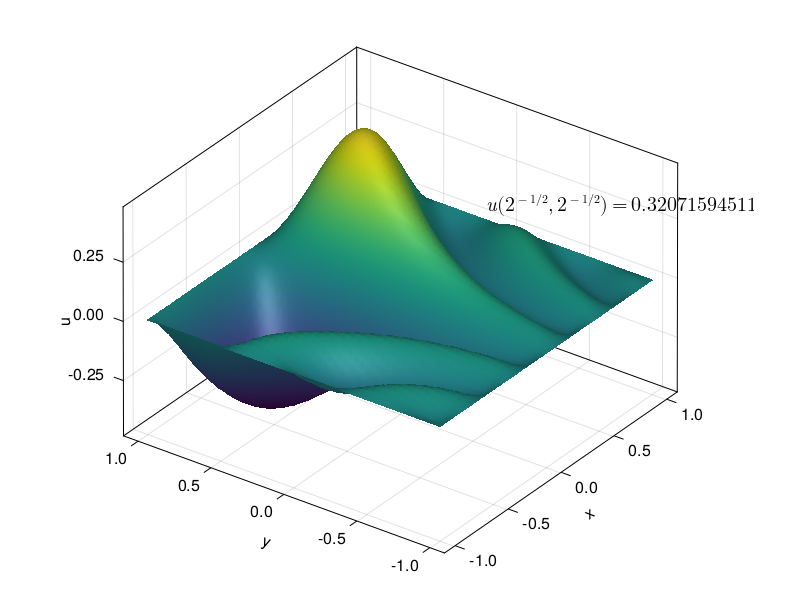

In [11]:
using LaTeXStrings
fig = Figure()
ax3 = Axis3(fig[1, 1], xlabel="x", ylabel="y", zlabel="u")
surface!(xx, yy, UU)
ax3.azimuth = 6π / 5; ax3.elevation = π / 6
val = f"{value:.11g}"
text!(0.4, -0.3, 0.3, text=latexstring("u(2^{-1/2},\\,2^{-1/2}) = "*val))
fig

## 2D Helmholtz

An important variation on the Poisson equation is the **Helmholtz equation**, which plays a major role in wave propagation:

$$
\Delta u + k^2 u = f(x,y),
$$

where $k$ is a real parameter. Here is an example solution:

### p17: Helmholtz eq. 

$$u_{xx} + u_{yy} + k^2 u = f$$

In [12]:
N = 24
# Set up spectral grid and tensor product Helmholtz operator:
⊗ = kron
D, x = D, y = cheb(N)
F = [exp(-10 * ((y - 1)^2 + (x - 0.5)^2)) for x in x[2:N], y in y[2:N]]
D² = (D^2)[2:N, 2:N]
k = 9
L = I(N-1) ⊗ D² + D² ⊗ I(N-1) + k^2 * I

# Solve for u, reshape to 2D grid, and plot:
u = L \ vec(F)
U = zeros(N+1, N+1)
U[2:N, 2:N] = reshape(u, N-1, N-1)
xx = yy = -1:1/50:1
UU = gridinterp(U, xx, yy)
value = U[N÷2 + 1, N÷2 + 1]

0.011722570002652808

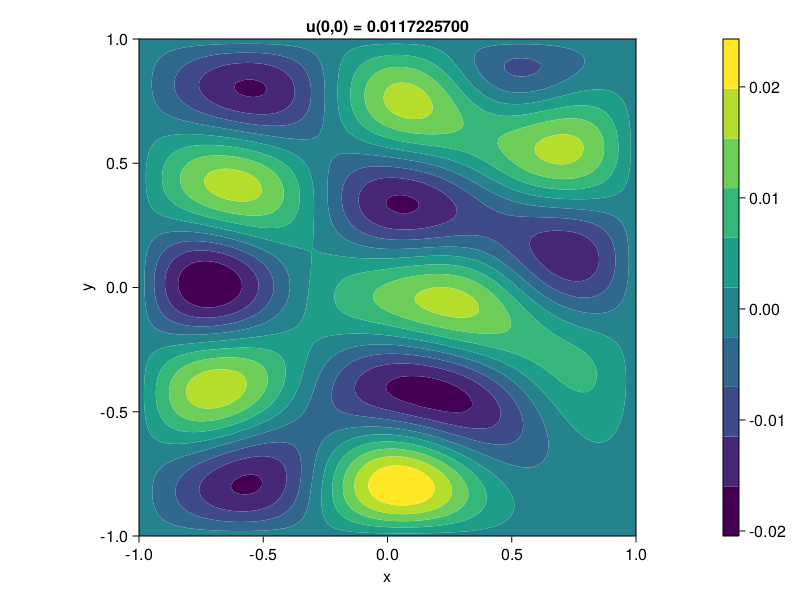

In [13]:
fig = Figure()
Axis(
    fig[1, 1], 
    aspect = DataAspect(), xlabel="x", ylabel="y", 
    title = f"u(0,0) = {value:.10f}"
)
co = contourf!(xx, yy, UU)
Colorbar(fig[1,2], co)
fig